## Pipeline Optimisation Thru Genetic Algorithm

In [2]:
###############
### Imports ###
###############

# %cd ~/Dropbox/Newcastle/PhD/Notebooks/fair_pipes

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from copy import deepcopy
from itertools import cycle, permutations
from sklearn.linear_model import LogisticRegression as lr
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier as dt
from tqdm.notebook import tqdm, trange

# clf = dt()
clf = lr(max_iter=10000)
savepath = 'datasets/'

#############################
### Fairness Dictionaries ###
#############################

def dp(test):
    '''Demographic Parity'''
    upr = test[test.pa == 0].pred.value_counts(normalize=True).get(1, 0)
    fpr = test[test.pa == 1].pred.value_counts(normalize=True).get(1, 0)
    dp = abs(fpr - upr)
    return dp

def dpr(test):
    '''Demographic Parity Ratio'''
    upr = test[test.pa == 0].pred.value_counts(normalize=True).get(1, 0)
    fpr = test[test.pa == 1].pred.value_counts(normalize=True).get(1, 0)
    dpr = abs(upr / fpr) if fpr > 0 else 1 if upr == 0 else -1
    return dpr

def eo(test):
    '''Equality of Opportunity'''
    f_fnr = test[(test.pa == 1) & (test.label == 1)].pred.value_counts(normalize=True).get(0, 0)
    u_fnr = test[(test.pa == 0) & (test.label == 1)].pred.value_counts(normalize=True).get(0, 0)
    eo = abs(f_fnr - u_fnr)
    return eo

def eqOdds(test):
    '''Equalised Odds'''
    f_fnr = test[(test.pa == 1) & (test.label == 1)].pred.value_counts(normalize=True).get(0, 0)
    u_fnr =test[(test.pa == 0) & (test.label == 1)].pred.value_counts(normalize=True).get(0, 0)
    f_fpr = test[(test.pa == 1) & (test.label == 0)].pred.value_counts(normalize=True).get(1, 0)
    u_fpr = test[(test.pa == 0) & (test.label == 0)].pred.value_counts(normalize=True).get(1, 0)
    eq =  abs(f_fnr - u_fnr) + abs(f_fpr - u_fpr)
    return eq

def accu(test):
    return 1 - accuracy_score(test.label, test.pred)
def precision(test):
    return 1 - precision_score(test.label, test.pred)
def recall(test):
    return 1 - recall_score(test.label, test.pred)
def f1(test):
    return 1 - f1_score(test.label, test.pred)
def roc_auc(test):
    return 1 - roc_auc_score(test.label, test.pred)

fair_funcs = {
    'dp': dp,
    'eo': eo,
    'eqOdds': eqOdds,
    'accu': accu,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc_auc': roc_auc,
    'dpr': dpr,
}

############################
### Dataset Dictionaries ###
############################

income = {
    'df': 'income_ne_mv.csv',
    'pa': 'sex',
    'label': 'label',
}

compas = {
    'df': 'compas_ne_new.csv',
    'pa': 'race',
    'label': 'is_recid',
}

german = {
    'df': 'german_ne.csv',
    'pa': 'gender',
    'label': 'label',
}

titanic = {
    'df': 'Titanic_NoEnc.csv',
    'pa': 'Sex',
    'label': 'Survived'
}

# Dset dictionary
DSets = {
    'income': income,
    'compas': compas,
    'german': german,
    'titanic': titanic,
}

class Identity:
    def fit(self, X, y):
        return self
    def transform(self, X):
        return X

#########################
### Task Dictionaries ###
#########################

from category_encoders import (
    OneHotEncoder,
    OrdinalEncoder,
    TargetEncoder,
    LeaveOneOutEncoder,
    WOEEncoder,
    CountEncoder,
)
# from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import (
    SimpleImputer, 
#     IterativeImputer, 
#     KNNImputer,
)
from sklearn.feature_selection import (
#     VarianceThreshold,
    SelectKBest,
)
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    QuantileTransformer,
)
from imblearn.over_sampling import (
    RandomOverSampler,
#     SMOTE,
#     ADASYN,
)
from imblearn.under_sampling import (
    RandomUnderSampler,
#     ClusterCentroids,
)

def make_encode_dict(df_id, dset_d=DSets):
    global to_encode
    global encode_d
    df_name = dset_d[df_id]['df']
    df = pd.read_csv(savepath + df_name)
    to_encode = list(df.select_dtypes(include='object').columns)
    encode_d = {
        'onehot_enc': OneHotEncoder(cols=to_encode, drop_invariant=True),
        'ordinal_enc': OrdinalEncoder(cols=to_encode, drop_invariant=True),
        'target_enc': TargetEncoder(cols=to_encode, drop_invariant=True),
        'loo_enc': LeaveOneOutEncoder(cols=to_encode, drop_invariant=True),
        'woe_enc': WOEEncoder(cols=to_encode, drop_invariant=True),
        'count_enc': CountEncoder(cols=to_encode, drop_invariant=True),
    }
make_encode_dict('income')

impute_d = {
    'mean_imp': SimpleImputer(strategy='mean'),
    'median_imp': SimpleImputer(strategy='median'),
    'most_freq_imp': SimpleImputer(strategy='most_frequent'),
#     'iter_imp': IterativeImputer(),
#     'knn_imp': KNNImputer(),
}
    
def make_fSel_dict(df_id, dset_d=DSets):
    df_name = dset_d[df_id]['df']
    df = pd.read_csv(savepath + df_name)
    n_feats = df.shape[1] - 1
    n_sel = 10 if n_feats > 10 else n_feats - 1
    global fSel_d
    fSel_d = {
        'no_sel': Identity(),
    #     'var_sel': VarianceThreshold(0.1),
        'k_best_sel': SelectKBest(k=n_sel),
    }
make_fSel_dict('income')

scale_d = {
    'no_scale': Identity(),
    'max_abs_scale': MaxAbsScaler(),
    'min_max_scale': MinMaxScaler(),
    'norm_scale': Normalizer(),
    'quant_scale': QuantileTransformer(),
}

sample_d = {
    'no_samp': Identity(),
    'under_samp': RandomUnderSampler(),
    'over_samp': RandomOverSampler(),
#     'cluster_samp': ClusterCentroids(),
#     'adasyn_samp': ADASYN(),
#     'smote_samp': SMOTE(),
}

###############################
### Preprocessing Functions ###
###############################

def relab(name, dset_d=DSets, savepath=savepath):
    '''Rename PA and label adequately'''
    df = pd.read_csv(savepath + dset_d[name]['df'], header=0)
    pa = dset_d[name]['pa']
    label = dset_d[name]['label']
    df.rename(columns={pa:'pa', label:'label'}, inplace=True)
    
    # Change PA to 0, 1 for unfav, fav resp.
    prs = {s: df[df.pa == s].label.value_counts(normalize=True)[1]
           for s in df.pa.unique()}
    df.pa = [1 if s == max(prs) else 0 for s in df.pa]
    return df

def tt_split(df, test_frac=0.2):
    test = df.dropna().sample(frac=test_frac)
    train = df.drop(test.index)
    tt = {'train': train, 'test': test}
    return tt

def preprocess(df, task_list):
    df_mod = df.copy()
    
    for task in task_list:
        X = df_mod.drop('label', axis=1).dropna(axis=1, how='all')
        y = df_mod.label.values
        pa = df_mod.pa
        cols = X.columns
        df_fit = task.fit(X, y)
        # General case
        if not hasattr(task, 'fit_resample'):
            tX = df_fit.transform(X)
        # Special case for resampling methods
        else:
            tX, y = task.fit_resample(X, y)
        # Special cases for column modifiers
        if hasattr(df_fit, 'get_feature_names'):
            try:
                cols = df_fit.get_feature_names(input_features=cols)
            except (NameError, TypeError):
                cols = df_fit.get_feature_names()
        elif hasattr(df_fit, 'get_support'):
            sup = df_fit.get_support(indices=True)
            cols = [cols[s] for s in sup]
        df_mod = pd.DataFrame(tX, columns=cols)
        if not 'pa' in df_mod.columns:
            df_mod['pa'] = pa
        df_mod['label'] = y    
        
    return df_mod

def predict(train, test, clf=clf):
    '''Add predictions to test made by train-learned classifier'''
    tst = test.copy()
    X_train = train.drop(['label',], axis=1)
    y_train = train.label
    X_test = tst.drop(['label',], axis=1)
    clf.fit(X_train, y_train)
    tst['pred'] = clf.predict(X_test)
    return tst

def get_fairness(df, prep_d, fair_d=fair_funcs, cv=False, clf=clf):
    '''Get fairness metrics on test resulting from preprocessing train with the tasks in prep_d'''
    
    preps = {p: preprocess(df, prep_d[p]) for p in prep_d}
    
    if cv:
        preds = {}
        for p in preps:
            prp = preps[p].copy()
            X = prp.drop('label', axis=1)
            y = prp.label
            cv_pred = cross_val_predict(clf, X, y, cv=4, n_jobs=-1)
            preds[p] = prp.assign(pred=cv_pred)
    else:
        splits = {p: tt_split(preps[p]) for p in preps}
        outs = {'trains': {p: splits[p]['train'] for p in preps},
                'tests': {p: splits[p]['test'] for p in preps}}
        preds = {p: predict(outs['trains'][p], outs['tests'][p])
                 for p in preps}
    
    fair_metrics = {f: {p: fair_d[f](preds[p]) for p in preds}
                    for f in fair_d}
    
    return fair_metrics

###################################
### Genetic Algorithm Functions ###
###################################

def make_task_perms(tasks):
    global task_perms
    task_perms = list(permutations(tasks))
    return

def decode_pipes(pipes_d):
    end_d = {'fSel': 2, 'sample': 3, 'scale': 4}
    dec_pipes = {}
    for k in pipes_d:
        perm = pipes_d[k][-1]
        indices = [end_d[perm[i]] for i in range(len(perm))]
        dec_pipes[k] = pipes_d[k][0:2] + [pipes_d[k][i] for i in indices]
    return dec_pipes

def rep_avg(df_id, prep_d, to_opt, cv, gen, n_rep):
    '''Repeat and average the fairness metrics'''
    df = relab(df_id)
    
    # Experiment loop
    reps = []
    for i in range(n_rep):
        reps.append(get_fairness(df=df, prep_d=prep_d, cv=cv))
    
#     Average-out all experiments
    results = {f: {g: sum([reps[i][f][g] for i in range(n_rep)]) / n_rep
                   for g in reps[0][f]}
               for f in reps[0]}
    
    metrics = results.keys()
    metrics_lc = ['dp', 'eo', 'eqOdds', 'accu']
    pipe_names = results['dp'].keys()
    mod_results = {n: {m: results[m][n] for m in metrics} for n in pipe_names}
    
    for n in mod_results:
        mod_results[n]['gen'] = gen
        mod_results[n]['lin_comb'] = sum([coef*mod_results[n][met]
                                          for coef, met in zip(to_opt, metrics_lc)])
    
    return mod_results

def make_results_df(results):
    df = pd.DataFrame.from_dict(results, orient='index')
    df.reset_index(level=0, inplace=True)
    df.rename(columns={'index': 'pipe'}, inplace=True)
    return df

# Generate initial population
def random_pop(df_id, pop_size, to_opt, cv, n_rep):
    pipes = {}
    for i in range(pop_size):
        encode_name = random.choice(list(encode_d))
        impute_name = random.choice(list(impute_d))
        fSel_name = random.choice(list(fSel_d))
        sample_name = random.choice(list(sample_d))
        scale_name = random.choice(list(scale_d))
        p_tasks = {'fSel': fSel_name, 'sample':sample_name, 'scale': scale_name}
        perm = random.choice(task_perms)
        name_list = [encode_name, impute_name] + [p_tasks[name] for name in perm]
        pipe_name = ','.join(name_list)
        pipe_start = [encode_d[encode_name], impute_d[impute_name]]
        pipe_end = [fSel_d[fSel_name], sample_d[sample_name], scale_d[scale_name], perm]
        pipe = pipe_start + pipe_end
        pipes[pipe_name] = pipe
    
    prep_d = decode_pipes(pipes)
    res = rep_avg(df_id, prep_d, to_opt, cv, 0, n_rep)
    pop = {'pipes': pipes, 'results': res}
    return pop

def crossover(parents):
    splits, pipes = [], []
    for k in parents:
        splits.append(k.split(','))
        pipes.append(parents[k])
    co_point = random.randrange(len(pipes[0]))
    c_splits, c_pipes = deepcopy(splits), deepcopy(pipes)
    perms = [pipes[i][-1] for i in range(2)]
    permute_ds = {i: {perms[i][j]: splits[i][len(splits) - len(perms[i]) + j - 2]
                      for j in range(len(perms[i]))} for i in range(2)}
    task_index_d = {2: 'fSel', 3: 'sample', 4: 'scale'}
    
    for i in range(2):
        k = (i + 1) % 2
        c_pipes[i][co_point] = pipes[k][co_point]
        if co_point == (len(pipes[0]) - 1):
            perm = perms[k]
            const_length = len(c_splits[i]) - len(perm)
            c_splits[i] = c_splits[i][:const_length] + [permute_ds[i][key] for key in perm]
        elif co_point in [2, 3, 4]:
            task_type = task_index_d[co_point]
            original_task = permute_ds[i][task_type]
            ot_index = c_splits[i].index(original_task)
            new_task = permute_ds[k][task_type]
            c_splits[i][ot_index] = new_task
        else:
            c_splits[i][co_point] = splits[k][co_point]
    
    c_joins = [','.join(c_splits[i]) for i in range(2)]
    children = {c_joins[i]: c_pipes[i] for i in range(2)}
    return children

def mutate(population, mut_ratio):
    pop = population.copy()
    index_dicts = {0: encode_d, 1: impute_d, 2: fSel_d, 3: sample_d, 4: scale_d}
    task_index_d = {2: 'fSel', 3: 'sample', 4: 'scale'}
    to_remove = []
    to_add = {}
    
    for k in pop:
        split_key = k.split(',')
        tasks = pop[k].copy()
        chrom_r = range(len(pop[k]))
        
        for i in chrom_r:
            ru = random.uniform(0, 1)
            
            if ru < mut_ratio:
                to_remove.append(k)
                
                if i in range(2):
                    new_task_name = random.choice([x for x in index_dicts[i] if x != split_key[i]])
                    new_task = index_dicts[i][new_task_name]
                    split_key[i] = new_task_name
                    tasks[i] = new_task
                
                elif i in range(2, chrom_r[-1]):
                    task_type = task_index_d[i]
                    split_index = tasks[5].index(task_type) + 2
                    new_task_name = random.choice([x for x in index_dicts[i] if x != split_key[split_index]])
                    new_task = index_dicts[i][new_task_name]
                    split_key[split_index] = new_task_name
                    tasks[i] = new_task
                
                else:
                    sk = split_key.copy()
                    perm = tasks[i]
                    new_perm = random.choice([t for t in task_perms if t != perm])
                    for v in task_index_d.values():
                        sk[2+new_perm.index(v)] = split_key[2+perm.index(v)]
                    tasks[i] = new_perm
                    split_key = sk
                
        new_name = ','.join(split_key)
        new_pipe = tasks
        to_add[new_name] = new_pipe
    
    for r in to_remove:
        pop.pop(r, None)
    pop.update(to_add)
    return pop

def next_pop(df_id, pop_dict, co_ratio, mut_ratio, to_opt, cv, gen, n_rep):
    pop = pop_dict['pipes']
    pop_size = len(pop)
    tnc = int(co_ratio * pop_size)
    n_children = tnc if tnc % 2 == 0 else tnc - 1 
    n_reps = int(n_children / 2)
    n_survivors = pop_size - n_children - 1
    
    res = pop_dict['results']
    sorted_res = {k: v for k, v in sorted(res.items(),
                                          key=lambda item: item[1]['lin_comb'])}
    sorted_pipe_names = list(sorted_res)
    
    # Generate Children
    next_pop = {}
    rep_den = sum(range(pop_size+1))
    rep_probs = [(pop_size - i) / rep_den for i in range(pop_size)]
    for r in range(n_reps):
        parent_names = list(np.random.choice(sorted_pipe_names, size=2,
                                             replace=False, p=rep_probs))
        parents = {n: pop[n] for n in parent_names}
        children = crossover(parents)
        next_pop.update(children)
    
    # Add survivors from prev generation
    p_surv_names = sorted_pipe_names[1:]
    surv_den = sum(range(pop_size))
    surv_probs = [(pop_size - 1 - i) / surv_den for i in range(pop_size - 1)]
    surv_names = list(np.random.choice(p_surv_names, size=n_survivors,
                                       replace=False, p=surv_probs))
    survivors = {n: pop[n] for n in surv_names}
    next_pop.update(survivors)
    
    # Mutate next_pop
    next_pop = mutate(next_pop, mut_ratio)
    
    # Save non-mutated best pipe from prev generation
    top_pipe = sorted_pipe_names[0]
    next_pop[top_pipe] = pop[top_pipe]
    
    # Complete gen with more mutations if necessary
    while len(next_pop) < pop_size:
        n_needed = pop_size - len(next_pop)
        p_surv_names = sorted_pipe_names
        surv_den = sum(range(pop_size + 1))
        surv_probs = [(pop_size - i) / surv_den for i in range(pop_size)]
        surv_names = list(np.random.choice(p_surv_names, size=n_needed,
                                           replace=False, p=surv_probs))
        survivors = {n: pop[n] for n in surv_names}
        mut_survs = mutate(survivors, mut_ratio)
        next_pop.update(mut_survs)
    
    # Get results for new gen
    prep_d = decode_pipes(next_pop)
    new_res = rep_avg(df_id, prep_d, to_opt, cv, gen, n_rep)
    pop = {'pipes': next_pop, 'results': new_res}
    return pop

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
def gen_pipe_opt(df_id, opt_list=[(1, 0, 0, 0)], pop_size=20, n_gens=10,
                 co_ratio=0.6, mut_ratio=0.15, cv=False, n_rep=1):
    
    # recreate necessary dicts and lists
    make_encode_dict(df_id)
    make_fSel_dict(df_id)
    tasks = ['fSel', 'scale', 'sample']
    make_task_perms(tasks)
    
    metrics = ['dp', 'eo', 'eqOdds', 'accu']
    opt_cycle = cycle(opt_list)
    to_opt = next(opt_cycle)
    pop_dict = random_pop(df_id, pop_size, to_opt, cv, n_rep)
    results_df = make_results_df(pop_dict['results'])
    
    for i in range(n_gens):
#     for i in trange(n_gens, desc='Generation'):
        to_opt = next(opt_cycle)
        pop_dict = next_pop(df_id, pop_dict, co_ratio, mut_ratio,
                            to_opt, cv, i+1, n_rep)
        partial_df = make_results_df(pop_dict['results'])
        results_df = results_df.append(partial_df, ignore_index=True)
    out = {'last_gen': pop_dict, 'results': results_df}
    return out

# Benchmarking

In [ ]:
import time

dsets = ['income', 'compas', 'german', 'titanic']
pipe_times = {dset: {} for dset in dsets}

seed_everything()

for dset in dsets:
    for dp_imp in range(0, 1.1, 0.1):
        pipe_times[dset][dp_imp] = {}
        for i in range(100):
            tic = time.process_time()
            ol = [(dp_imp, 0, 0, 1 - dp_imp)]
            gen_pipe_opt(dset, pop_size=10, n_gens=20, co_ratio=0.6, mut_ratio=0.15, opt_list=ol, cv=True)
            toc = time.process_time()
            pipe_times[dset][dp_imp].append(toc - tic)

In [2]:
#######################################
# Search Metrics in Ground Truth Hack #
#######################################

def rep_avg(df_id, prep_d, to_opt, cv, gen, n_rep):
    
    ex_df = pd.read_csv(f'results/{df_id}_cv_exhaustive.csv', index_col='pipe')
    metrics = ('dp', 'dpr', 'eo', 'eqOdds', 'accu', 'precision', 'recall', 'f1', 'roc_auc')
    metrics_lc = ['dp', 'eo', 'eqOdds', 'accu']
    pipe_names = list(prep_d.keys())
    mod_results = {n: {m: ex_df.loc[n, m] for m in metrics} for n in pipe_names}
    
    for n in mod_results:
        mod_results[n]['gen'] = gen
        mod_results[n]['lin_comb'] = sum([coef*mod_results[n][met]
                                          for coef, met in zip(to_opt, metrics_lc)])
    
    return mod_results

In [3]:
################
### Test Run ###
################
import time
tic = time.process_time()
ol = [(0, 0, 0, 1)]
test_exp = gen_pipe_opt('compas', pop_size=10, n_gens=0, opt_list=ol, cv=True)
te = test_exp['results']
toc = time.process_time()
print("Elapsed time:", toc, tic) 
print("Elapsed time during the whole program in seconds:", toc-tic) 
te

Elapsed time: 4.740824439 4.674934969
Elapsed time during the whole program in seconds: 0.06588947000000012


,pipe,dp,dpr,eo,eqOdds,accu,precision,recall,f1,roc_auc,gen,lin_comb
0,"onehot_enc,most_freq_imp,k_best_sel,no_samp,ma...",0.074264,1.358457,0.042353,0.048188,0.087516,0.015232,0.249257,0.148023,0.127560,0,0.087516
1,"woe_enc,most_freq_imp,min_max_scale,no_samp,no...",0.076883,1.375851,0.050235,0.056653,0.088422,0.015286,0.251958,0.149785,0.128910,0,0.088422
2,"target_enc,median_imp,over_samp,no_sel,max_abs...",0.195007,1.569015,0.190044,0.331006,0.317616,0.307380,0.344191,0.326291,0.317616,0,0.317616
3,"ordinal_enc,median_imp,no_sel,over_samp,min_ma...",0.189145,1.545609,0.183877,0.320538,0.318841,0.308592,0.345614,0.327614,0.318841,0,0.318841
4,"loo_enc,mean_imp,no_scale,over_samp,k_best_sel",0.195365,1.559323,0.191112,0.340200,0.342415,0.335948,0.362104,0.349299,0.342415,0,0.342415
5,"count_enc,mean_imp,over_samp,k_best_sel,norm_s...",0.611856,-1.000000,0.325174,0.866289,0.437096,0.439445,0.343948,0.402569,0.437096,0,0.437096
6,"count_enc,mean_imp,over_samp,norm_scale,no_sel",0.583240,-1.000000,0.342960,0.843333,0.427179,0.434876,0.368171,0.403393,0.427179,0,0.427179
7,"loo_enc,median_imp,quant_scale,over_samp,no_sel",0.177578,1.506862,0.154004,0.287573,0.296332,0.283002,0.327049,0.305728,0.296332,0,0.296332
8,"loo_enc,most_freq_imp,no_sel,under_samp,no_scale",0.076442,1.234373,0.003867,0.027092,0.145321,0.029956,0.268034,0.165649,0.145321,0,0.145321
9,"count_enc,mean_imp,k_best_sel,under_samp,no_scale",0.209108,1.613641,0.212431,0.368489,0.340744,0.334252,0.360286,0.347534,0.340744,0,0.340744


# Hyper param tuning

In [4]:
def pareto_front(df, cols=['accu', 'dp']):
    arr = df[cols].to_numpy()
    is_front = np.ones(arr.shape[0], dtype = bool)
    for i, row in enumerate(arr):
        if is_front[i]:
            is_front[is_front] = np.any(arr[is_front] < row, axis=1)  # Keep any point with a lower metric
            is_front[i] = True  # And keep self
    front_df = df.iloc[is_front]
    fdf = front_df.sort_values(by=[cols[0]])
    return fdf

def haus(df1, df2, var1='accu', var2='dp'):
    def dist(row1, row2):
        return ((row1[var1] - row2[var1])**2 + (row1[var2] - row2[var2])**2)**0.5
    passes = [(df1, df2), (df2, df1)]
    haus = 0
    for p in passes:
        for i in range(p[0].shape[0]):
            dists = []
            r1 = p[0].iloc[i]
            for j in range(p[1].shape[0]):
                r2 = p[1].iloc[j]
                dists.append(dist(r1, r2))
            haus = min(dists) if min(dists) > haus else haus
    return haus

In [11]:
income_ex = pd.read_csv(f'results/income_cv_exhaustive.csv')
all_par = pareto_front(income_ex)
hds = {j: [] for j in range(10, 210, 10)}
for i in range(100):
    for j in range(10, 210, 10):
        samp = income_ex.sample(n=j)
        samp_par = pareto_front(samp)
        hds[j].append(haus(all_par, samp_par))

avg_hd = {j: sum(hds[j])/len(hds[j]) for j in hds}

In [12]:
exp_hds = {j: [] for j in range(10, 210, 10)}

for i in range(100):
    for j in range(20):
        exp = gen_pipe_opt('income',
                           co_ratio=0.89,
                           mut_ratio=0.27,
                           n_gens=j+1,
                           opt_list=[(0.37, 0, 0, 0.63)],
                           cv=True)
        exp_par = pareto_front(exp['results'])
        exp_hds[(j + 1)*10].append(haus(all_par, exp_par))
        
avg_exp_hds = {j: sum(exp_hds[j])/len(exp_hds[j]) for j in hds}

<AxesSubplot:xlabel='sample_size', ylabel='distance'>

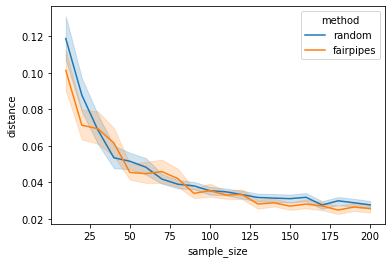

In [32]:
rows = []
for key in hds:
    for i in range(100):
        rows.append([key, hds[key][i], exp_hds[key][i]])
rows

haus_df = pd.DataFrame(rows, columns=['sample_size', 'random', 'fairpipes'])
melt_df = haus_df.melt(id_vars=['sample_size'],
                       value_vars=['random', 'fairpipes'],
                       var_name='method',
                       value_name='distance')

sns.lineplot(data=melt_df, x='sample_size', y='distance', hue='method')

In [35]:
exp['results']

,pipe,dp,dpr,eo,eqOdds,accu,precision,recall,f1,roc_auc,gen,lin_comb
0,"ordinal_enc,mean_imp,norm_scale,over_samp,no_sel",0.411800,-1.000000,0.408146,0.750034,0.339889,0.360112,0.267600,0.316976,0.339889,0,0.366496
1,"woe_enc,mean_imp,no_sel,over_samp,max_abs_scale",0.414644,0.358019,0.217576,0.479260,0.191579,0.211328,0.157373,0.185243,0.191579,0,0.274113
2,"target_enc,most_freq_imp,no_scale,under_samp,k...",0.414942,0.347880,0.230192,0.490949,0.197700,0.211786,0.173258,0.192983,0.197700,0,0.278079
3,"onehot_enc,most_freq_imp,under_samp,max_abs_sc...",0.393359,0.383009,0.182153,0.427142,0.190949,0.209392,0.159207,0.185075,0.190949,0,0.265841
4,"woe_enc,median_imp,norm_scale,under_samp,no_sel",0.290223,-1.000000,0.273789,0.395217,0.218400,0.257684,0.137321,0.202020,0.218400,0,0.244975
...,...,...,...,...,...,...,...,...,...,...,...,...
205,"onehot_enc,median_imp,k_best_sel,under_samp,qu...",0.423316,0.334076,0.281263,0.542414,0.210623,0.222761,0.188722,0.206108,0.210623,20,0.289319
206,"count_enc,most_freq_imp,no_sel,no_samp,norm_scale",0.025996,-1.000000,0.821035,0.828228,0.206628,0.246006,0.789313,0.670654,0.405558,20,0.139794
207,"woe_enc,median_imp,no_sel,no_samp,max_abs_scale",0.193059,0.216618,0.209894,0.295896,0.160622,0.280404,0.454406,0.379370,0.260921,20,0.172624
208,"woe_enc,mean_imp,no_samp,no_sel,norm_scale",0.006220,-1.000000,0.963528,0.966030,0.238690,0.386139,0.976279,0.954322,0.490506,20,0.152677


In [39]:
dsets = ['income', 'compas', 'german', 'titanic']
experiments = {}

for dset in tqdm(dsets, desc='DSet', leave=False):
    experiments[dset] = {}
    for dp_imp in tqdm([0.1*k for k in range(11)], desc='DP Importance', leave=False):
        experiments[dset][dp_imp] = {}
        for mut_ratio in tqdm([0.05*k for k in range(11)], desc='Mut. Ratio', leave=False):
            experiments[dset][dp_imp][mut_ratio] = []
            for i in trange(20, desc='Replicate', leave=False):
                exp = gen_pipe_opt(dset,
                                   co_ratio=0.6,
                                   mut_ratio=mut_ratio,
                                   n_gens=20,
                                   opt_list=[(dp_imp, 0, 0, 1 - dp_imp)],
                                   cv=True)
                best = exp['results']['lin_comb'].min()
                experiments[dset][dp_imp][mut_ratio].append(best)

DSet:   0%|          | 0/4 [00:00<?, ?it/s]

DP Importance:   0%|          | 0/11 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

DP Importance:   0%|          | 0/11 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

DP Importance:   0%|          | 0/11 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

DP Importance:   0%|          | 0/11 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Mut. Ratio:   0%|          | 0/11 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

In [41]:
dsets = ['income', 'compas', 'german', 'titanic']
co_experiments = {}

for dset in tqdm(dsets, desc='DSet', leave=False):
    co_experiments[dset] = {}
    for dp_imp in tqdm([0.1*k for k in range(11)], desc='DP Importance', leave=False):
        co_experiments[dset][dp_imp] = {}
        for co_ratio in tqdm([0.1*k for k in range(10)], desc='C.O. Ratio', leave=False):
            co_experiments[dset][dp_imp][co_ratio] = []
            for i in trange(20, desc='Replicate', leave=False):
                exp = gen_pipe_opt(dset,
                                   co_ratio=co_ratio,
                                   mut_ratio=0.1,
                                   n_gens=20,
                                   opt_list=[(dp_imp, 0, 0, 1 - dp_imp)],
                                   cv=True)
                best = exp['results']['lin_comb'].min()
                co_experiments[dset][dp_imp][co_ratio].append(best)

DSet:   0%|          | 0/4 [00:00<?, ?it/s]

DP Importance:   0%|          | 0/11 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

DP Importance:   0%|          | 0/11 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

DP Importance:   0%|          | 0/11 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

DP Importance:   0%|          | 0/11 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

C.O. Ratio:   0%|          | 0/10 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

Replicate:   0%|          | 0/20 [00:00<?, ?it/s]

In [45]:
mut_rows = []
co_rows = []

for dset in dsets:
    for dp_imp in [0.1*k for k in range(11)]:
        for i in range(20):
            for mut_ratio in [0.05*k for k in range(11)]:
                mut_rows.append([dset, dp_imp, mut_ratio, experiments[dset][dp_imp][mut_ratio][i]])
            for co_ratio in [0.1*k for k in range(10)]:
                co_rows.append([dset, dp_imp, co_ratio, co_experiments[dset][dp_imp][co_ratio][i]])

mut_df = pd.DataFrame(mut_rows, columns=['dset', 'dp_importance', 'mut_ratio', 'best'])
co_df = pd.DataFrame(co_rows, columns=['dset', 'dp_importance', 'co_ratio', 'best'])

mut_df.to_csv('mutation_exp.csv', index=False)
co_df.to_csv('crossover_exp.csv', index=False)

In [3]:
co_df = pd.read_csv('crossover_exp.csv')
mut_df = pd.read_csv('mutation_exp.csv')

In [4]:
mut_df.dp_importance.replace({0: '0, 20', 0.1: '2, 18', 0.2: '4, 16', 0.3: '6, 14', 0.4: '8, 12', 0.5: '10, 10', 0.6000000000000001: '12, 8', 0.7000000000000001: '14, 6', 0.8: '16, 4', 0.9: '18, 2', 1: '20, 0'}, inplace=True)
co_df.dp_importance.replace({0: '0, 20', 0.1: '2, 18', 0.2: '4, 16', 0.3: '6, 14', 0.4: '8, 12', 0.5: '10, 10', 0.6000000000000001: '12, 8', 0.7000000000000001: '14, 6', 0.8: '16, 4', 0.9: '18, 2', 1: '20, 0'}, inplace=True)

In [5]:
mut_df = mut_df[mut_df.dp_importance.isin(['0, 20', '4, 16', '8, 12', '12, 8', '16, 4', '20, 0'])]
co_df = co_df[co_df.dp_importance.isin(['0, 20', '4, 16', '8, 12', '12, 8', '16, 4', '20, 0'])]

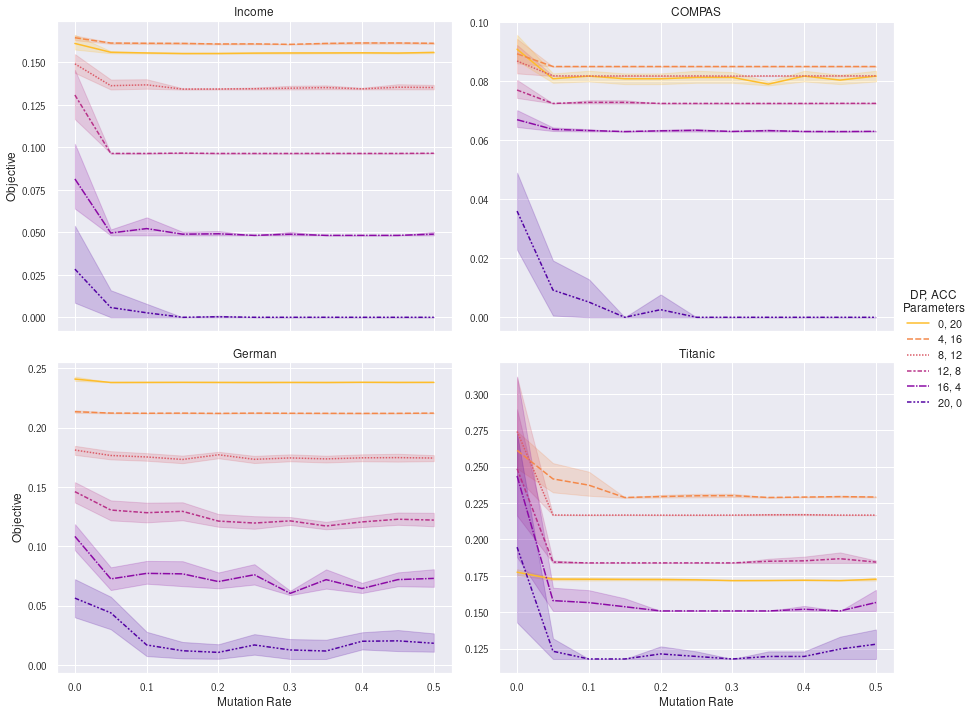

In [6]:
import matplotlib as mpl

mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Helvetica"
mpl.rcParams['text.usetex'] = True

mpl.rc('text.latex', preamble=r'\usepackage{sansmathfonts}\usepackage{helvet}\renewcommand{\rmdefault}{\sfdefault}')

sns.set_theme()

lstyles = ['solid', (0, (4,1)), (0, (1,1)), (0, (3,1,2,1)), (0, (5,1,1,1)), (0, (3,1,1,1,1,1))]

fig, axs = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=False)
g1 = sns.lineplot(data=mut_df[mut_df['dset'] == 'income'], x='mut_ratio', y='best',
                  hue='dp_importance', style='dp_importance', ax=axs[0, 0], palette='plasma_r')
g2 = sns.lineplot(data=mut_df[mut_df['dset'] == 'compas'], x='mut_ratio', y='best',
                  hue='dp_importance', style='dp_importance', ax=axs[0, 1], palette='plasma_r')
g3 = sns.lineplot(data=mut_df[mut_df['dset'] == 'german'], x='mut_ratio', y='best',
                  hue='dp_importance', style='dp_importance', ax=axs[1, 0], palette='plasma_r')
g4 = sns.lineplot(data=mut_df[mut_df['dset'] == 'titanic'], x='mut_ratio', y='best',
                  hue='dp_importance', style='dp_importance', ax=axs[1, 1], palette='plasma_r')

handles, labels = g1.get_legend_handles_labels()
g1.legend_.remove()
g2.legend_.remove()
g3.legend_.remove()
g4.legend_.remove()

axs[0, 0].set(title='Income')
axs[0, 1].set(title='COMPAS')
axs[1, 0].set(title='German')
axs[1, 1].set(title='Titanic')

ylabs = ['Objective', '']
for i in range(2):
    axs[i, 0].set(ylabel=ylabs[0])
    axs[i, 1].set(ylabel=ylabs[1])
    axs[1, i].set(xlabel='Mutation Rate')

l = fig.legend(handles, labels, title='DP, ACC\nParameters', bbox_to_anchor=(0.9, 0.5), loc='center left', frameon=False)
plt.setp(l.get_title(), multialignment='center')
fig.subplots_adjust(hspace=0.1, wspace=0.12)
plt.savefig(f"plots/mut_ratios.pdf", bbox_inches='tight')
plt.show()

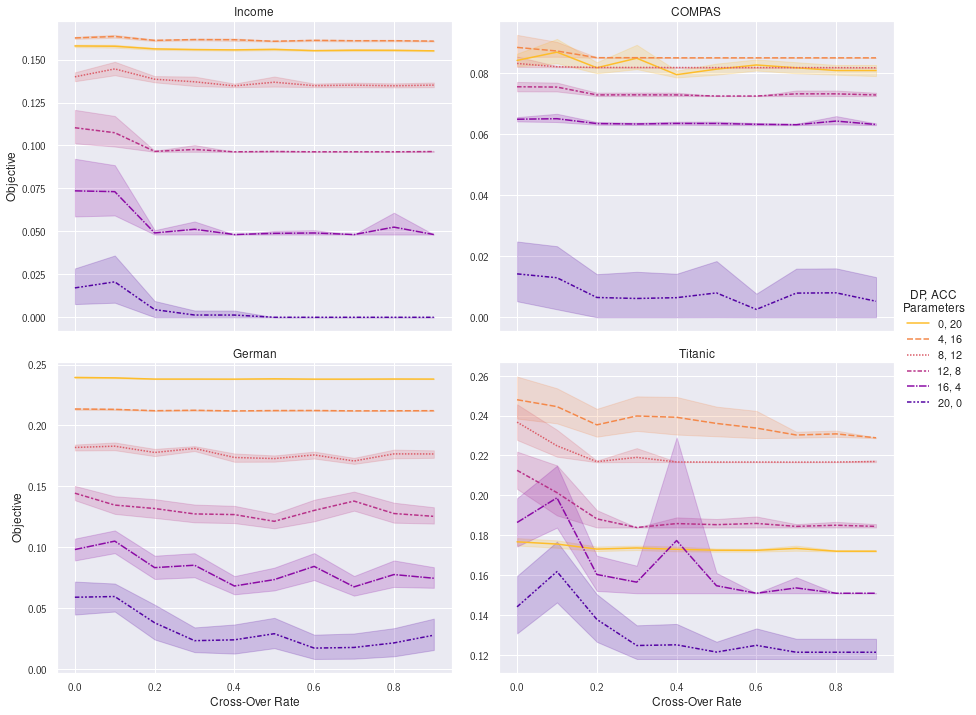

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=False)
g1 = sns.lineplot(data=co_df[co_df['dset'] == 'income'], x='co_ratio', y='best', hue='dp_importance', style='dp_importance', ax=axs[0, 0], palette='plasma_r')
g2 = sns.lineplot(data=co_df[co_df['dset'] == 'compas'], x='co_ratio', y='best', hue='dp_importance', style='dp_importance', ax=axs[0, 1], palette='plasma_r')
g3 = sns.lineplot(data=co_df[co_df['dset'] == 'german'], x='co_ratio', y='best', hue='dp_importance', style='dp_importance', ax=axs[1, 0], palette='plasma_r')
g4 = sns.lineplot(data=co_df[co_df['dset'] == 'titanic'], x='co_ratio', y='best', hue='dp_importance', style='dp_importance', ax=axs[1, 1], palette='plasma_r')

handles, labels = g1.get_legend_handles_labels()
g1.legend_.remove()
g2.legend_.remove()
g3.legend_.remove()
g4.legend_.remove()

axs[0, 0].set(title='Income')
axs[0, 1].set(title='COMPAS')
axs[1, 0].set(title='German')
axs[1, 1].set(title='Titanic')

ylabs = ['Objective', '']
for i in range(2):
    axs[i, 0].set(ylabel=ylabs[0])
    axs[i, 1].set(ylabel=ylabs[1])
    axs[1, i].set(xlabel='Cross-Over Rate')

l = fig.legend(handles, labels, title='DP, ACC\nParameters', bbox_to_anchor=(0.9, 0.5), loc='center left', frameon=False)
plt.setp(l.get_title(), multialignment='center')
fig.subplots_adjust(hspace=0.1, wspace=0.12)
plt.savefig(f"plots/co_ratios.pdf", bbox_inches='tight')
plt.show()

In [36]:
import optuna

dsets = ['income', 'compas', 'german', 'titanic']
# strats = {'accu':[(0, 0, 0, 1)], 'dp': [(1, 0, 0, 0)], 'accu + dp':[(1, 0, 0, 1)]}

best_dfs = {dset: pd.read_csv(f'results/{dset}_cv_exhaustive.csv') for dset in dsets}
paretos = {dset: pareto_front(best_dfs[dset]) for dset in dsets}
best_params = {dset: {} for dset in dsets}

for dset in dsets:
    bdf = paretos[dset]
    def objective(trial):
#         cor = trial.suggest_float('cor', 0, 1)
        mut = trial.suggest_float('mut', 0, 1)
        dp_imp = trial.suggest_float('dp_imp', 0, 1)
        ol = [(dp_imp, 0, 0, 1 - dp_imp)] 
        bests = []
        for i in range(20):
            exp = gen_pipe_opt(dset,
                               co_ratio=0.6,
                               mut_ratio=mut,
                               n_gens=20,
                               opt_list=ol,
                               cv=True)
            best = exp['results']['lin_comb'].min()
            bests.append(best)
        av_best = sum(bests) / len(bests)
            
#             par_df = pareto_front(df)
#             dist = haus(bdf, par_df)
#             dists.append(dist)
#         av_dist = sum(dists) / len(dists)
        return av_best
    study = optuna.create_study()
    study.optimize(objective, n_trials=100)
    best_params[dset] = study.best_params
    best_params[dset]['value'] = study.best_value

[I 2021-09-09 13:02:09,988] A new study created in memory with name: no-name-96fc05eb-9396-4140-a1af-f04974f0651f
[I 2021-09-09 13:02:16,430] Trial 0 finished with value: 0.016266998146125495 and parameters: {'mut': 0.8881568586199768, 'dp_imp': 0.9501598585467455}. Best is trial 0 with value: 0.016266998146125495.
[I 2021-09-09 13:02:22,883] Trial 1 finished with value: 0.15840900245955247 and parameters: {'mut': 0.5906086870572831, 'dp_imp': 0.2754530875342609}. Best is trial 0 with value: 0.016266998146125495.
[I 2021-09-09 13:02:29,336] Trial 2 finished with value: 0.08854202999879499 and parameters: {'mut': 0.21582199543857838, 'dp_imp': 0.6323606125639972}. Best is trial 0 with value: 0.016266998146125495.
[I 2021-09-09 13:02:35,786] Trial 3 finished with value: 0.013267021113669255 and parameters: {'mut': 0.5087515040267772, 'dp_imp': 0.9449083405729718}. Best is trial 3 with value: 0.013267021113669255.
[I 2021-09-09 13:02:42,249] Trial 4 finished with value: 0.1609639316377870

KeyboardInterrupt: 

In [6]:
avg_dset_vals = {dset:{val: best_params[dset][val] for val in ('cor', 'mut', 'dp_imp', 'value')} for dset in dsets}
avg_dset_vals

{'income': {'cor': 0.8921849814388456,
  'mut': 0.2683865151204781,
  'dp_imp': 0.3679129288798438,
  'value': 0.019766913947518127},
 'compas': {'cor': 0.9292950071750287,
  'mut': 0.2548951852450954,
  'dp_imp': 0.898600152437236,
  'value': 0.025650980268818162},
 'german': {'cor': 0.9770254066994761,
  'mut': 0.5933470887602861,
  'dp_imp': 0.8942022914235299,
  'value': 0.018943401883543768},
 'titanic': {'cor': 0.8286051349377239,
  'mut': 0.593630810517734,
  'dp_imp': 0.7836033485049723,
  'value': 0.019602542701052498}}

In [7]:
dsets_minus = dsets.copy()
dsets_minus.remove('titanic')
avg_vals = {val: sum(best_params[dset][val] for dset in dsets_minus) / len(dsets_minus) for val in ('cor', 'mut', 'dp_imp', 'value')}
avg_vals

{'cor': 0.9328351317711169,
 'mut': 0.37220959637528656,
 'dp_imp': 0.7202384575802032,
 'value': 0.021453765366626687}

In [8]:
import yaml
print(yaml.dump(best_params))

compas:
  cor: 0.9292950071750287
  dp_imp: 0.898600152437236
  mut: 0.2548951852450954
  value: 0.025650980268818162
german:
  cor: 0.9770254066994761
  dp_imp: 0.8942022914235299
  mut: 0.5933470887602861
  value: 0.018943401883543768
income:
  cor: 0.8921849814388456
  dp_imp: 0.3679129288798438
  mut: 0.2683865151204781
  value: 0.019766913947518127
titanic:
  cor: 0.8286051349377239
  dp_imp: 0.7836033485049723
  mut: 0.593630810517734
  value: 0.019602542701052498



/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_contour is experimental (supported from v2.2.0). The interface can change in the future.

[W 2021-09-09 09:47:13,767] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


<AxesSubplot:title={'center':'Contour Plot'}, xlabel='dp_imp', ylabel='mut'>

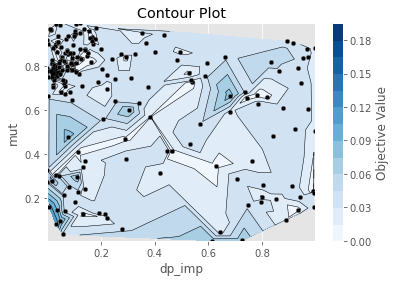

In [27]:
optuna.visualization.matplotlib.plot_contour(study, params=["dp_imp", "mut"])

/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

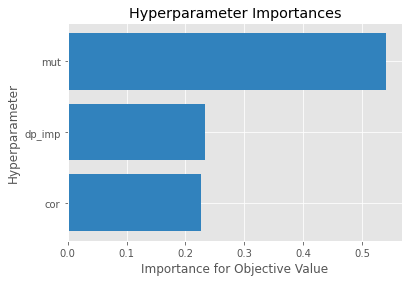

In [26]:
optuna.visualization.matplotlib.plot_param_importances(study)

### Repetitions

In [2]:
import os
from itertools import product
from multiprocessing import Pool  
from tqdm.notebook import tqdm, trange

# datasets = ['income', 'compas', 'german', 'titanic']
datasets = ['compas']
seed_everything(42)
seeds = [random.randint(1, 100000) for i in range(64)]
dset_seed = list(product(datasets, seeds))

In [ ]:
def repetition(p):
    dataset = p[0]
    seed = p[1]
    batch_size = 20

    make_encode_dict(dataset)
    make_fSel_dict(dataset)

    l = list(product(encode_d, impute_d))
    l = [list(e) for e in l]

    m = list(product(fSel_d, sample_d, scale_d))
    m = [list(permutations(e)) for e in m]
    m = [tup for lst in m for tup in lst]
    m = [list(e) for e in m]

    names = list(product(l, m))
    names = [tuple(e[0] + e[1]) for e in names]

    l = list(product(encode_d.values(), impute_d.values()))
    l = [list(e) for e in l]

    m = list(product(fSel_d.values(), sample_d.values(), scale_d.values()))
    m = [list(permutations(e)) for e in m]
    m = [tup for lst in m for tup in lst]
    m = [list(e) for e in m]

    pipes = list(product(l, m))
    pipes = [e[0] + e[1] for e in pipes]

    names = [names[i: i + batch_size] for i in range(0, len(names), batch_size)]
    pipes = [pipes[i: i + batch_size] for i in range(0, len(pipes), batch_size)]

    pipe_dicts = [{n: p for n, p in zip(curr_name, curr_pipe)}
                  for curr_name, curr_pipe in zip(names, pipes)]

    seed_everything(seed)
    all_res = [rep_avg(df_id=dataset, prep_d=p, to_opt=(0,0,0,1),
                       cv=True, gen=0, n_rep=1)
               for p in tqdm(pipe_dicts, desc='Batch')]

    dfs = [pd.DataFrame.from_dict(e, orient='index') for e in all_res]
    dfs = [e.reset_index(level=[0,1,2,3,4]) for e in dfs]

    for e in dfs:
        e['pipe'] = (e['level_0']
                     + ',' + e['level_1']
                     + ',' + e['level_2']
                     + ',' + e['level_3']
                     + ',' + e['level_4'])

    levels = [f'level_{str(i)}' for i in range(5)]
    dfs = [e.drop(columns=levels) for e in dfs]
    df = pd.concat(dfs, ignore_index=True)
    cols = ['pipe', 'dp', 'dpr', 'eo', 'eqOdds', 'accu', 'precision', 'recall', 'f1', 'roc_auc']
    df = df[cols]
    df.to_csv(f'results/{dataset}_cv_exhaustive_{seed}.csv', index=False)

if __name__ == '__main__':
    with Pool() as p:
        with tqdm(total=len(dset_seed), desc='Repetition') as pbar:
            for i, _ in enumerate(p.imap_unordered(repetition, dset_seed)):
                pbar.update()

In [ ]:
#############################
### Generate Ground Truth ###
#############################

from itertools import product

dsets = ['compas', 'german', 'income', 'titanic']

for d in tqdm(dsets, desc='Dataset'):
    dataset = d
    batch_size = 20

    make_encode_dict(dataset)
    make_fSel_dict(dataset)

    l = list(product(encode_d, impute_d))
    l = [list(e) for e in l]

    m = list(product(fSel_d, sample_d, scale_d))
    m = [list(permutations(e)) for e in m]
    m = [tup for lst in m for tup in lst]
    m = [list(e) for e in m]

    names = list(product(l, m))
    names = [tuple(e[0] + e[1]) for e in names]

    l = list(product(encode_d.values(), impute_d.values()))
    l = [list(e) for e in l]

    m = list(product(fSel_d.values(), sample_d.values(), scale_d.values()))
    m = [list(permutations(e)) for e in m]
    m = [tup for lst in m for tup in lst]
    m = [list(e) for e in m]

    pipes = list(product(l, m))
    pipes = [e[0] + e[1] for e in pipes]

    names = [names[i: i + batch_size] for i in range(0, len(names), batch_size)]
    pipes = [pipes[i: i + batch_size] for i in range(0, len(pipes), batch_size)]

    pipe_dicts = [{n: p for n, p in zip(curr_name, curr_pipe)}
                  for curr_name, curr_pipe in zip(names, pipes)]

    seed_everything()
    all_res = [rep_avg(df_id=dataset, prep_d=p, to_opt=(0,0,0,1),
                       cv=True, gen=0, n_rep=1)
               for p in tqdm(pipe_dicts, desc='Batch')]

    dfs = [pd.DataFrame.from_dict(e, orient='index') for e in all_res]
    dfs = [e.reset_index(level=[0,1,2,3,4]) for e in dfs]

    levels = [f'level_{str(i)}' for i in range(5)]
    for e in dfs:
#         e['pipe'] = ','.join(levels)
       e['pipe'] = ','.join([e[l] for l in levels])

    dfs = [e.drop(columns=levels) for e in dfs]
    df = pd.concat(dfs, ignore_index=True)
    cols = ['pipe', 'dp', 'dpr', 'eo', 'eqOdds', 'accu', 'precision', 'recall', 'f1', 'roc_auc']
    df = df[cols]
    df.to_csv(f'results/{dataset}_cv_exhaustive.csv', index=False)

In [ ]:
test = [f'num_{str(i)}' for i in range(4)]
','.join(test)

In [ ]:
########################
### Ground Truth EDA ###
########################

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm, trange

sns.set_theme(context='notebook', style='whitegrid', palette='Dark2')
sns.set(rc={'figure.figsize':(5, 5)})
colormap = mpl.cm.Dark2.colors

dset_names = {
    'compas': 'COMPAS',
    'german': 'German Credit',
    'income': 'Adult Income',
    'titanic': 'Titanic',
}

task_names = {
    'enc': 'Encoding',
    'imp': 'Imputing',
    'samp': 'Sampling',
    'sel': 'Feature Selection',
    'scale': 'Feature Scaling',
    'perm': 'Permutation',
}

def plot_grid(dataset, var, show=False):
    # Load data
    ex_df = pd.read_csv(f'results/{dataset}_cv_exhaustive.csv')
    
    # Create directory if necessary
    if not os.path.exists(f'plots/exhaustive/{dataset}'):
        os.makedirs(f'plots/exhaustive/{dataset}')
        
    # Create necessary columns
    ex_df['splits'] = ex_df['pipe'].str.split(',')
    tasks = {'sel': [], 'samp': [], 'scale': []}
    perms = []
    for i in range(ex_df.shape[0]):
        perm = []
        for j in range(2,5):
            spl = ex_df.splits[i][j].rpartition('_')
            k = spl[2]
            v = spl[0]
            tasks[k].append(v)
            perm.append(k)
        perm = tuple(perm)
        perms.append(perm)
    ex_df['enc'] = [ex_df.splits[i][0].rpartition('_')[0]
                    for i in range(ex_df.shape[0])]
    ex_df['imp'] = [ex_df.splits[i][1].rpartition('_')[0]
                    for i in range(ex_df.shape[0])]
    for t in tasks:
        ex_df[t] = tasks[t]
    ex_df['perm'] = perms
    ex_df.drop(columns=['splits'], inplace=True)
    
    # Plot
    g = sns.PairGrid(ex_df[['dp', 'eo', 'eqOdds', 'accu', var]],
                     hue=var, diag_sharey=False)
    g.map_diag(sns.histplot, multiple='stack', bins=20)
    g.map_offdiag(sns.scatterplot, alpha=0.2)
    g.add_legend(title=task_names[var])
    g.fig.subplots_adjust(top=0.95)
    g.fig.suptitle(f'{dset_names[dataset]} data, {task_names[var]}', fontsize=16)
    plt.savefig(f'plots/exhaustive/{dataset}/encoding.pdf', bbox_inches='tight')
    if not show:
        plt.close()

In [ ]:
###################################
### Generate All PairGrid Plots ###
###################################

datasets = ['compas', 'german', 'income', 'titanic']
task_cats = ['enc', 'imp', 'samp', 'scale', 'sel', 'perm']

for dataset in tqdm(datasets, desc='Dataset'):
    for task in tqdm(task_cats, desc='Task', leave=False):
        plot_grid(dataset, task)

In [ ]:
############################
### Show Single PairGrid ###
############################

plot_grid('income', 'scale', show=True)

# Experiments

In [14]:
import os
from itertools import product
from multiprocessing import Pool  

datasets = ['compas']
# datasets = ['income', 'compas', 'german', 'titanic']
seed_everything(42)
seeds = [random.randint(1, 100000) for i in range(128)]
dset_seed = list(product(datasets, seeds))

In [18]:
# Single Metric Optimisation
all_metrics = [[(1,0,0,0)], [(0,1,0,0)], [(0,0,1,0)], [(0,0,0,1)]]

def repetition(p):
    dataset = p[0]
    seed = p[1]
    experiments = {}
    
    for m in all_metrics:
        seed_everything(seed)
        experiments[m[0]] = gen_pipe_opt(dataset, pop_size=10, n_gens=20,
                                         opt_list=m, cv=True)

    exp_dfs = [experiments[k]['results'] for k in experiments]
    exp_keys = list(experiments)

    for k, e in zip(exp_keys, exp_dfs):
        e['opt_metric'] = str(k)

    all_metrics_df = pd.concat(exp_dfs, ignore_index=True)
    all_metrics_df.drop(columns=['lin_comb'], inplace=True)
    all_metrics_df['seed'] = seed
    all_metrics_df.to_csv(f'results/repeats/{dataset}_all_metrics_{str(seed)}.csv', index=False)
    
# for ds in tqdm(dset_seed, desc='Repetition'):
#     repetition(ds)
if __name__ == '__main__':
    with Pool() as p:
        with tqdm(total=len(dset_seed), desc='Repetition') as pbar:
            for i, _ in enumerate(p.imap_unordered(repetition, dset_seed)):
                pbar.update()

Repetition:   0%|          | 0/128 [00:00<?, ?it/s]

In [19]:
# Linear combinations of DP and Accuracy
dp_acc_cc = [[(i, 0, 0, 10-i)] for i in range(11)]

def repetition(p):
    dataset = p[0]
    seed = p[1]
    experiments = {}
    
    for i in range(11):
        seed_everything(seed)
        experiments[(i, 10-i)] = gen_pipe_opt(dataset, pop_size=10, n_gens=20,
                                              opt_list=dp_acc_cc[i], cv=True)

    exp_dfs = [experiments[k]['results'] for k in experiments]
    exp_keys = list(experiments)

    for k, e in zip(exp_keys, exp_dfs):
        e['dp_acc_ratio'] = str(k)

    dp_acc_df = pd.concat(exp_dfs, ignore_index=True)
    dp_acc_df.drop(columns=['lin_comb'], inplace=True)
    dp_acc_df['seed'] = seed
    dp_acc_df.to_csv(f'results/repeats/{dataset}_dp_acc_ratios_{str(seed)}.csv', index=False)
        
if __name__ == '__main__':
    with Pool() as p:
        with tqdm(total=len(dset_seed), desc='Repetition') as pbar:
            for i, _ in enumerate(p.imap_unordered(repetition, dset_seed)):
                pbar.update()

Repetition:   0%|          | 0/128 [00:00<?, ?it/s]

In [20]:
# DP first, then Accu
dp_acc_reps = [[(1,0,0,0)]*i + [(0,0,0,1)]*(20-i) for i in range(0,21,4)]

def repetition(p):
    dataset = p[0]
    seed = p[1]
    experiments = {}
    
    for i in range(6):
        seed_everything(seed)
        experiments[(4*i, 20-4*i)] = gen_pipe_opt(dataset, pop_size=10, n_gens=20,
                                                  opt_list=dp_acc_reps[i], cv=True)

    exp_dfs = [experiments[k]['results'] for k in experiments]
    exp_keys = list(experiments)

    for k, e in zip(exp_keys, exp_dfs):
        e['dp_acc_reps'] = str(k)

    dp_acc_reps_df = pd.concat(exp_dfs, ignore_index=True)
    dp_acc_reps_df.drop(columns=['lin_comb'], inplace=True)
    dp_acc_reps_df['seed'] = seed
    dp_acc_reps_df.to_csv(f'results/repeats/{dataset}_dp_acc_reps_{str(seed)}.csv', index=False)
        
if __name__ == '__main__':
    with Pool() as p:
        with tqdm(total=len(dset_seed), desc='Repetition') as pbar:
            for i, _ in enumerate(p.imap_unordered(repetition, dset_seed)):
                pbar.update()

Repetition:   0%|          | 0/128 [00:00<?, ?it/s]

In [21]:
# Accu first, then DP
acc_dp_reps = [[(0,0,0,1)]*i + [(1,0,0,0)]*(20-i) for i in range(0,21,4)]

def repetition(p):
    dataset = p[0]
    seed = p[1]
    experiments = {}
    
    for i in range(6):
        seed_everything(seed)
        experiments[(4*i, 20-4*i)] = gen_pipe_opt(dataset, pop_size=10, n_gens=20,
                                                  opt_list=acc_dp_reps[i], cv=True)

    exp_dfs = [experiments[k]['results'] for k in experiments]
    exp_keys = list(experiments)

    for k, e in zip(exp_keys, exp_dfs):
        e['dp_acc_reps'] = str(k)

    acc_dp_reps_df = pd.concat(exp_dfs, ignore_index=True)
    acc_dp_reps_df.drop(columns=['lin_comb'], inplace=True)
    acc_dp_reps_df['seed'] = seed
    acc_dp_reps_df.to_csv(f'results/repeats/{dataset}_acc_dp_reps_{str(seed)}.csv', index=False)
            
if __name__ == '__main__':
    with Pool() as p:
        with tqdm(total=len(dset_seed), desc='Repetition') as pbar:
            for i, _ in enumerate(p.imap_unordered(repetition, dset_seed)):
                pbar.update()

Repetition:   0%|          | 0/128 [00:00<?, ?it/s]

In [22]:
# Full 20 gens then switch for both accu and dp
reps = [[(0,0,0,1)]*20 + [(1,0,0,0)]*(20), [(1,0,0,0)]*20 + [(0,0,0,1)]*(20)]

def repetition(p):
    dataset = p[0]
    seed = p[1]
    experiments = {}
    exp_keys = ['accu_dp', 'dp_accu']
    
    for i in range(2):
        seed_everything(seed)
        experiments[exp_keys[i]] = gen_pipe_opt(dataset, pop_size=10, n_gens=40,
                                                  opt_list=reps[i], cv=True)

    exp_dfs = [experiments[k]['results'] for k in experiments]

    for k, e in zip(exp_keys, exp_dfs):
        e['reps'] = str(k)

    acc_dp_reps_df = pd.concat(exp_dfs, ignore_index=True)
    acc_dp_reps_df.drop(columns=['lin_comb'], inplace=True)
    acc_dp_reps_df['seed'] = seed
    acc_dp_reps_df.to_csv(f'results/repeats/{dataset}_reps_{str(seed)}.csv', index=False)
            
if __name__ == '__main__':
    with Pool() as p:
        with tqdm(total=len(dset_seed), desc='Repetition') as pbar:
            for i, _ in enumerate(p.imap_unordered(repetition, dset_seed)):
                pbar.update()

Repetition:   0%|          | 0/128 [00:00<?, ?it/s]